[Adversarial Discriminative Domain Adaptation](https://arxiv.org/abs/1702.05464) 

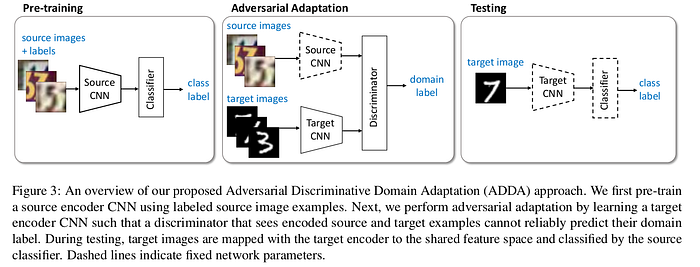

### Libraries 📚⬇

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import random, math, cv2
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor

import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [2]:
MNIST_DATA_DIR = Path('./')
BSDS_DATA_DIR = Path('./bsds500')
MODEL_FILE = Path('./best_source_weights_mnist.pth')

batch_size = 64
iterations = 500
epochs = 4
k_disc = 1
k_clf = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def visualize_digits(dataset, k=80, mnistm=False, cmap=None, title=None):
    
    ncols = 20
    indices = random.choices(range(len(dataset)), k=k)
    nrows = math.floor(len(indices)/ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols,nrows+0.4), gridspec_kw=dict(wspace=0.1, hspace=0.1), subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)
    fig.suptitle(title, fontsize=20)
    
    for list_idx, image_idx in enumerate(indices[:ncols*nrows]):
        ax = axes_flat[list_idx]
        image = dataset[image_idx][0]
        image = image.numpy().transpose(1, 2, 0)
        ax.imshow(image, cmap=cmap)

def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

def loop_iterable(iterable):
    while True:
        yield from iterable

class GrayscaleToRgb:
    """Convert a grayscale image to rgb"""
    def __call__(self, image):
        image = np.array(image)
        image = np.dstack([image, image, image])
        return Image.fromarray(image)

### Define Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.LogSoftmax(),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

In [5]:
source_model = Net().to(device)
if MODEL_FILE:
    source_model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
source_model.eval()
set_requires_grad(source_model, requires_grad=False)

clf = source_model
source_model = source_model.feature_extractor

target_model = Net().to(device)
if MODEL_FILE:
    target_model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
target_model = target_model.feature_extractor

discriminator = nn.Sequential(
    nn.Linear(320, 120),
    nn.ReLU(),
    nn.Linear(120, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).to(device)

### Define Dataset Classes

In [6]:
class BSDS500(Dataset):

    def __init__(self):
        image_folder = BSDS_DATA_DIR / 'images'
        self.image_files = list(map(str, image_folder.glob('*/*.jpg')))

    def __getitem__(self, i):
        image = cv2.imread(self.image_files[i], cv2.IMREAD_COLOR)
        tensor = torch.from_numpy(image.transpose(2, 0, 1))
        return tensor

    def __len__(self):
        return len(self.image_files)


class MNISTM(Dataset):

    def __init__(self, train=True):
        super(MNISTM, self).__init__()
        self.mnist = datasets.MNIST(MNIST_DATA_DIR / 'mnist', train=train,
                                    download=True)
        self.bsds = BSDS500()
        # Fix RNG so the same images are used for blending
        self.rng = np.random.RandomState(42)

    def __getitem__(self, i):
        digit, label = self.mnist[i]
        digit = transforms.ToTensor()(digit)
        bsds_image = self._random_bsds_image()
        patch = self._random_patch(bsds_image)
        patch = patch.float() / 255
        blend = torch.abs(patch - digit)
        return blend, label

    def _random_patch(self, image, size=(28, 28)):
        _, im_height, im_width = image.shape
        x = self.rng.randint(0, im_width-size[1])
        y = self.rng.randint(0, im_height-size[0])
        return image[:, y:y+size[0], x:x+size[1]]

    def _random_bsds_image(self):
        i = self.rng.choice(len(self.bsds))
        return self.bsds[i]

    def __len__(self):
        return len(self.mnist)

### Get Dataset & Dataloaders

In [7]:
half_batch = batch_size // 2

source_dataset = MNIST(MNIST_DATA_DIR/'mnist', train=True, download=True, transform=Compose([GrayscaleToRgb(), ToTensor()]))
source_loader = DataLoader(source_dataset, batch_size=half_batch, shuffle=True, num_workers=16, pin_memory=True)

target_train_dataset, target_test_dataset = MNISTM(train=True), MNISTM(train=False)
target_train_loader = DataLoader(target_train_dataset, batch_size=half_batch, shuffle=True, num_workers=16, pin_memory=True)
target_test_loader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)

discriminator_optim = torch.optim.Adam(discriminator.parameters())
target_optim = torch.optim.Adam(target_model.parameters())
criterion_train = nn.BCEWithLogitsLoss()
criterion_test = nn.NLLLoss()

### Visualize MNIST-M & MNIST Data 🖼️

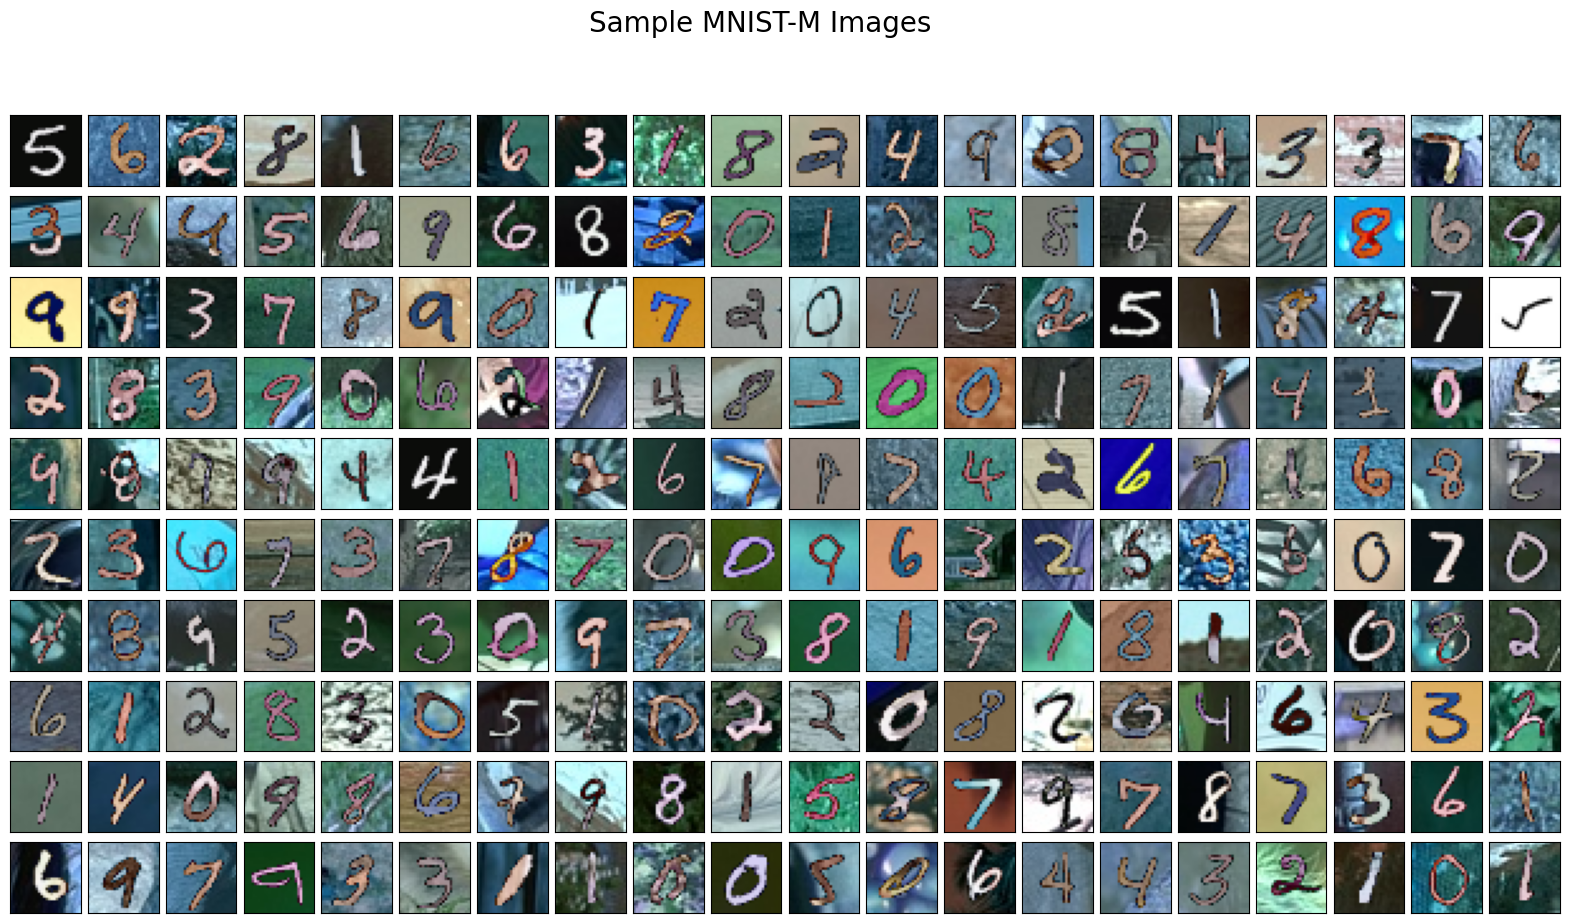

In [8]:
visualize_digits(dataset=target_train_dataset, k=200, mnistm=True, title='Sample MNIST-M Images')

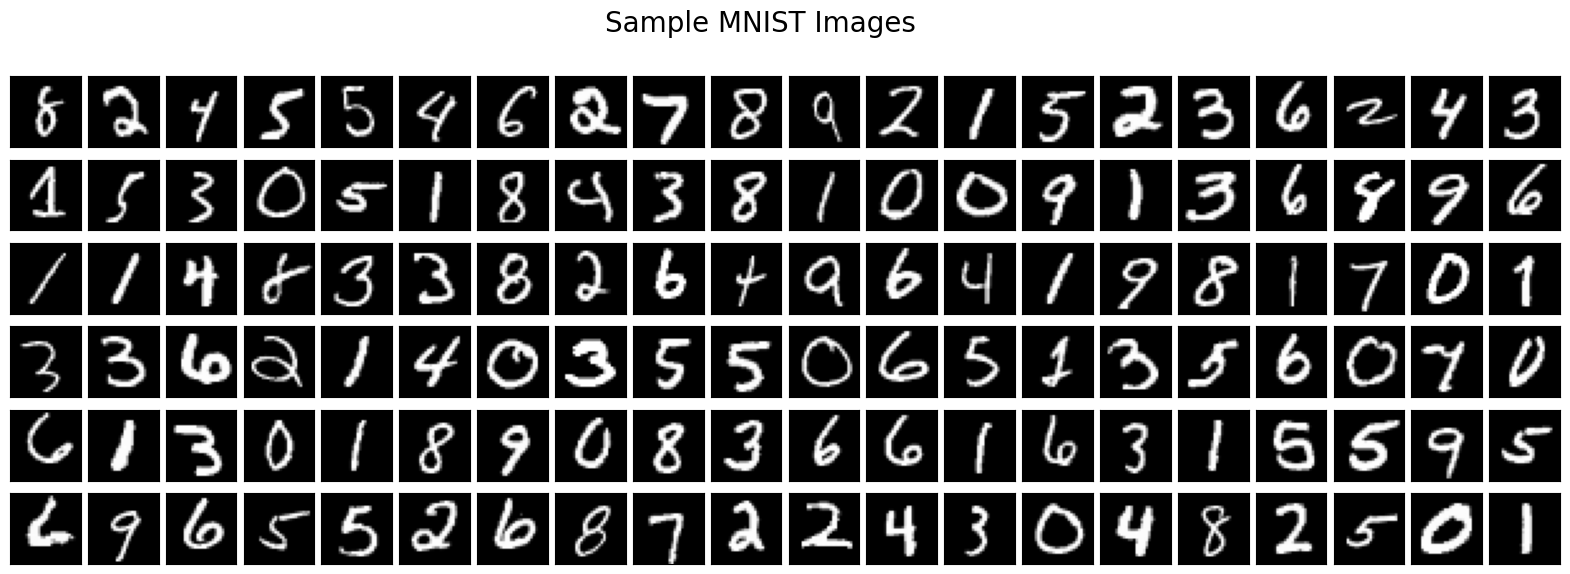

In [9]:
visualize_digits(dataset=source_dataset, k=120, cmap='gray', title='Sample MNIST Images')

### Adversarial Discriminative Domain Adaptation

In [10]:
disc_losses, disc_accuracies, disc_train_counter = [], [], []
clf_disc_losses, clf_disc_train_counter = [], []
clf_losses, clf_accuracies = [], []
clf_test_counter = [idx*iterations*k_clf*target_train_loader.batch_size for idx in range(0, epochs+1)]

In [11]:
test_loss, test_accuracy = 0, 0
clf.eval()
tqdm_bar = tqdm(target_test_loader, desc=f'Testing ', total=int(len(target_test_loader)))
for idx, (images, labels) in enumerate(tqdm_bar):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = clf(images)
        loss = criterion_test(outputs, labels)
    test_loss += loss.item()
    outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(device)
    test_accuracy += torch.mean((outputs == labels).type(torch.FloatTensor)).item()
    tqdm_bar.set_postfix(test_loss=(test_loss/(idx+1)), test_accuracy=test_accuracy/(idx+1))
clf_losses.append(test_loss/len(target_test_loader))
clf_accuracies.append(test_accuracy/len(target_test_loader))

Testing :   0%|          | 0/157 [00:00<?, ?it/s]

In [12]:
for epoch in range(epochs):
    target_batch_iterator = loop_iterable(target_train_loader)
    batch_iterator = zip(loop_iterable(source_loader), loop_iterable(target_train_loader))
    disc_loss, disc_accuracy = 0, 0
    clf_disc_loss = 0
    test_loss, test_accuracy = 0, 0
    tqdm_bar = tqdm(range(iterations), desc=f'Training Epoch {epoch} ', total=iterations)
    for iter_idx in tqdm_bar:
        # Train discriminator
        set_requires_grad(target_model, requires_grad=False)
        set_requires_grad(discriminator, requires_grad=True)
        for disc_idx in range(k_disc):
            (source_x, _), (target_x, _) = next(batch_iterator)
            source_x, target_x = source_x.to(device), target_x.to(device)
            source_features = source_model(source_x).view(source_x.shape[0], -1)
            target_features = target_model(target_x).view(target_x.shape[0], -1)
            discriminator_x = torch.cat([source_features, target_features])
            discriminator_y = torch.cat([torch.ones(source_x.shape[0], device=device), torch.zeros(target_x.shape[0], device=device)])
            preds = discriminator(discriminator_x).squeeze()
            loss = criterion_train(preds, discriminator_y)
            discriminator_optim.zero_grad()
            loss.backward()
            discriminator_optim.step()
            disc_loss += loss.item()
            disc_losses.append(loss.item())
            disc_batch_accuracy = ((preds > 0).long() == discriminator_y.long()).float().mean().item()
            disc_accuracy += disc_batch_accuracy
            disc_accuracies.append(disc_batch_accuracy)
            disc_train_counter.append((disc_idx+1)*source_x.size(0) + iter_idx*k_disc*target_train_loader.batch_size + epoch*iterations*k_disc*target_train_loader.batch_size)

        # Train classifier
        set_requires_grad(target_model, requires_grad=True)
        set_requires_grad(discriminator, requires_grad=False)
        for clf_idx in range(k_clf):
            _, (target_x, _) = next(batch_iterator)
            target_x = target_x.to(device)
            target_features = target_model(target_x).view(target_x.shape[0], -1)
            # Flipped Labels
            discriminator_y = torch.ones(target_x.shape[0], device=device)
            preds = discriminator(target_features).squeeze()
            loss = criterion_train(preds, discriminator_y)
            target_optim.zero_grad()
            loss.backward()
            target_optim.step()
            clf_disc_loss += loss.item()
            clf_disc_losses.append(loss.item())
            clf_disc_train_counter.append(source_x.size(0) + clf_idx*half_batch + iter_idx*k_clf*half_batch + epoch*iterations*k_clf*half_batch)
        tqdm_bar.set_postfix(disc_loss=disc_loss/((iter_idx+1)*k_disc), disc_accuracy=disc_accuracy/((iter_idx+1)*k_disc),
                             clf_disc_loss=clf_disc_loss/((iter_idx+1)*k_clf))

    # Test full target model
    test_loss, test_accuracy = 0, 0
    clf.feature_extractor = target_model
    clf.eval()
    tqdm_bar = tqdm(target_test_loader, desc=f'Testing Epoch {epoch} (Full Target Model)', total=int(len(target_test_loader)))
    for idx, (images, labels) in enumerate(tqdm_bar):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = clf(images)
            loss = criterion_test(outputs, labels)
        test_loss += loss.item()
        outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(device)
        test_accuracy += torch.mean((outputs == labels).type(torch.FloatTensor)).item()
        tqdm_bar.set_postfix(test_loss=(test_loss/(idx+1)), test_accuracy=test_accuracy/(idx+1))
    clf_losses.append(test_loss/len(target_test_loader))
    clf_accuracies.append(test_accuracy/len(target_test_loader))
    if np.argmax(clf_accuracies) == len(clf_accuracies)-1:
        torch.save(clf.state_dict(), 'adda_target_weights.pth')
        

Training Epoch 0 :   0%|          | 0/500 [00:00<?, ?it/s]

Testing Epoch 0 (Full Target Model):   0%|          | 0/157 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/500 [00:00<?, ?it/s]

Testing Epoch 1 (Full Target Model):   0%|          | 0/157 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/500 [00:00<?, ?it/s]

Testing Epoch 2 (Full Target Model):   0%|          | 0/157 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/500 [00:00<?, ?it/s]

Testing Epoch 3 (Full Target Model):   0%|          | 0/157 [00:00<?, ?it/s]

### Visualize Training & Testing Results 📈

In [15]:
import plotly.subplots as sp
fig = sp.make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=disc_train_counter, y=disc_losses, mode='lines', name='Disc Loss'), secondary_y=False)
fig.add_trace(go.Scatter(x=disc_train_counter, y=disc_accuracies, mode='lines', name='Disc Accuracy', line_color='lightseagreen'), secondary_y=True)
fig.update_layout(
    width=1000,
    height=500,
    title="Discriminator Loss vs Accuracy")
fig.update_xaxes(title_text="Number of training examples seen")
fig.update_yaxes(title_text="Discriminator <b>Loss</b> (BCE)", secondary_y=False)
fig.update_yaxes(title_text="Discriminator <b>Accuracy</b>", secondary_y=True)
fig.show()

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=clf_disc_train_counter, y=clf_disc_losses, mode='lines', name='Clf-Disc Train Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Clf-Disc Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Binary Cross Entropy Loss"),
fig.show()

In [17]:
fig = plotly.subplots.make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=clf_test_counter, y=clf_accuracies, marker_symbol='star-diamond', 
                         marker_line_color="orange", marker_line_width=1, marker_size=9, mode='lines+markers', 
                         name='Target Accuracy'), secondary_y=False)
fig.add_trace(go.Scatter(x=clf_test_counter, y=clf_losses, marker_symbol='star-square', 
                         marker_line_color="lightseagreen", marker_line_width=1, marker_size=9, mode='lines+markers',
                         name='Target Loss'), secondary_y=True)
fig.update_layout(
    width=1000,
    height=500,
    title="Full Target Model Loss vs Accuracy")
fig.update_xaxes(title_text="Number of training examples seen")
fig.update_yaxes(title_text="Target <b>Accuracy</b>", secondary_y=False)
fig.update_yaxes(title_text="Target <b>Loss</b> (NLLLoss)", secondary_y=True)
fig.show()